# Introduction
Inspired by predicting sales of things dependent of multivariate observations (eg day of week, holidays) and so on

## Prepare data
Before using deflate train and test data that has been downloaded before (kaggle competitions download -c rossmann-store-sales).

```
unzip -d ./input/rossmann-store-sales.zip ./input/
```

## Further literature
- [kaggle competition](https://www.kaggle.com/c/rossmann-store-sales)
- https://www.mdpi.com/2306-5729/4/1/15
- http://cs229.stanford.edu/proj2015/205_report.pdf


In [10]:
from sklearn.model_selection import learning_curve
from matplotlib.axes import Axes
from matplotlib.figure import Figure
from typing import Tuple
from sklearn.model_selection._split import _BaseKFold
from pandas import DataFrame
from statsmodels.regression.linear_model import RegressionResults
from sklearn.metrics import mean_absolute_error, median_absolute_error, r2_score, make_scorer
import numpy as np
from statsmodels.tsa.stattools import kpss, adfuller
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from statsmodels.tsa.arima.model import ARIMAResults
from seaborn import histplot, relplot, lineplot
from pandas import Series
from statsmodels.graphics.tsaplots import plot_acf

class TimeSeriesSplitWrapper(_BaseKFold):
    def __init__(self, n_last_test_items:int, **kwargs):
        self.n_last_test_items = n_last_test_items
        self.splitter_ = TimeSeriesSplit(**kwargs)

    def split(self, X=None, y=None, groups=None):
        for train, test in self.splitter_.split(X):
            yield (train, test[-self.n_last_test_items:])

def enginner_categorial_dummy(x: DataFrame, col: str) -> DataFrame:
    """
    Creates dummy columns of col named 'col' of X matrix
    :param x:
    :param col:
    :return:
    """
    s_cat = x[col].astype('category')
    x = pd.concat([x, pd.get_dummies(s_cat, prefix=col, dtype=float)], axis=1)
    return x

def map_kpss_description(result: Tuple[float, float, int, dict[str, float]]) -> Series:
    return Series(result[:4], index=['t-statistic value', 'pvalue', 'usedlags', 'critical values'])

def map_adf_description(result: Tuple[float, float, int, int, dict[str, float]]) -> Series:
    return Series(result[:5], index=['t-statistic value', 'pvalue', 'usedlags', 'nobs', 'critical values'])


def plot_series_hist_acf_kpss(data: Series, lags=5, plot_lag_plot=False, hist_bins=15):
    # Yt
    f = relplot(data=data, kind='line', markers=True, height=20.0, aspect=1.5)
    plt.show()

    # ACF
    f = plot_acf(data, lags=lags)
    plt.show()

    ax = histplot(data, bins=hist_bins, kde=True)
    plt.show()

    # https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.kpss.html#
    # 1. The residuals (should be white noise) see
    ' - KPSS test statistic result -'
    print(map_kpss_description(kpss(data)))
    ' - ADF test statistic result -'
    print(map_adf_description(adfuller(data)))

    # Compare median and mean
    #data.describe()

    # Lag plot
    if (plot_lag_plot is True):
        ax = lag_plot(series=data, lag=lags)
        plt.show()

def plot_actual_and_fitted_values(y: Series, model_fit: ARIMAResults):
    fitted_ = model_fit.fittedvalues[y.index]
    f, axes = plt.subplots(1, 1)
    f.set_size_inches(w=20, h=10)
    f = lineplot(data=pd.DataFrame({'actual': y, 'fitted': fitted_}), ax=axes)
    plt.show()

def plot_time_series(**kwargs):
    '''
    Plots multiple time series on same axes.
    :param kwargs:
    :return:
    '''
    f, axes = plt.subplots(1, 1)
    f.set_size_inches(w=20, h=10)
    f = lineplot(data=pd.DataFrame(data=kwargs), ax=axes)
    plt.show()

def plot_line(data: DataFrame, title: str='Unknwon title', xlabel='Not set', ylabel='Not set'):
    '''
    Plots multiple columns in same axes.
    :param data data frame to plot
    :return:
    '''
    f, axes = plt.subplots(1, 1)
    f.set_size_inches(w=20, h=10)
    axes.set_title(label=title)
    axes.set_xlabel(xlabel=xlabel)
    axes.set_ylabel(ylabel=ylabel)
    f = lineplot(data=data, ax=axes)
    plt.show()


def errors(y: Series, y_pred: Series) -> dict:
    diff_ = (y - y_pred)
    return {
        'RMSE': np.sqrt(mean_squared_error(y, y_pred, squared=True)),
        'MAPE': mean_absolute_percentage_error(y, y_pred),
        'MAE': mean_absolute_error(y, y_pred),
        'MEDIAN_AE': median_absolute_error(y, y_pred),
        'MAX_ABS': diff_.abs().max(),
        'MIN_ABS': diff_.abs().min()}

def model_errors_precalculated(res: RegressionResults):
    return {
        'RMSE / standard error (SE)': np.sqrt(res.mse_resid),  # https://otexts.com/fpp3/least-squares.html#standard-error-of-the-regression
        'RSQUARED': res.rsquared,
        'RSQUARED-ADJUSTED': res.rsquared_adj
    }


def model_errors(y: Series, model_fit):
    fitted:Series = model_fit.fittedvalues[y.index]
    return errors(y, fitted)

def plot_residuals_against_predictors(model_fit: RegressionResults, predictors: DataFrame):
    x_y = predictors.assign(Sales=model_fit.resid)
    f = pairplot(data=x_y, y_vars=['Sales'], x_vars=x_y.columns, height=20)
    plt.show()


def plot_fitted_against_residuals_ols(model_fit: RegressionResults):
    f = scatterplot(x=model_fit.fittedvalues, y=model_fit.resid)
    plt.xlabel("FITTED")
    plt.ylabel("RESIDUALS")
    plt.show()

def plot_fitted_against_residuals(fitted: Series, residuals: Series):
    f = scatterplot(x=fitted, y=residuals)
    plt.xlabel("FITTED")
    plt.ylabel("RESIDUALS")
    plt.show()


def r2_adjusted(r2: float, T: int, k: int) -> float:
    '''
    See https://otexts.com/fpp3/selecting-predictors.html#adjusted-r2
    :param r2:
    :param T: count of observations
    :param p: count of predictor variables
    :return:
    '''
    return 1-(1-r2)*(T-1)/(T-k-1)

def r2_adjusted_scorer(y, y_pred, **kwargs) -> float:
    r2_ = r2_score(y, y_pred)
    return r2_adjusted(r2_, **kwargs)

def to_learning_curve_df(train_sizes=np.linspace(0.05, 1.0, 36, endpoint=True), scoring=make_scorer(mean_squared_error), **kwargs) -> DataFrame:
    '''
    Calculates learning curve and calculates average of all cross validation scores for training and test scores.
    :param kwargs: arguments for scikti learning_curve
    :return:
    '''
    train_sizes, scores_train, scores_test = learning_curve(n_jobs=4, train_sizes=train_sizes, scoring=scoring, **kwargs)
    return DataFrame(data={'Training score': np.mean(scores_train, axis=1), 'Test scores':np.mean(scores_test, axis=1)}, index=train_sizes)


# Preprocessing
Feature engineering, create categorial columns

In [11]:
from sklearn.base import TransformerMixin, BaseEstimator
import pandas as pd
from pandas import DataFrame

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


class FeaturePreparation(TransformerMixin, BaseEstimator):

    def __init__(self, transform_pre_post_holiday_indicators: bool = False):
        """

        :type transform_pre_post_holiday_indicators: Transform pre/post indicators as dummy features
        """
        self.transform_pre_post_holiday_indicators_ = transform_pre_post_holiday_indicators

    def engineer_outliers_dummy_(self, X: DataFrame, y:Series):

        """
        Handle Sales == 0 as outlier and set "outlier" column as dummy variable to 1 and everything else to zero.
        See here why (https://otexts.com/fpp3/useful-predictors.html#dummy-variables)
        :return:
        """
        s_sales_zero_bin: Series = y == 0.0
        # set all columns to zero except outlier
        X[s_sales_zero_bin] = 0.0

        return X.assign(Outlier=s_sales_zero_bin.astype('float'))


    def transform(self, X: DataFrame) -> Tuple[DataFrame, Series]:

        # get data for one store
        # FEATURE ENGINEERING
        X_: DataFrame = X.groupby(by='Store').get_group(2).set_index('Date').sort_index()


        ## StateHoliday -> categorial
        X_ = enginner_categorial_dummy(X_, 'StateHoliday')

        ## Day of week -> categorial
        X_ = enginner_categorial_dummy(X_, 'DayOfWeek')
        X_['Month'] = X_.index.month
        dummies = pd.get_dummies(X_['Month'], prefix='Month', dtype=float)
        X_ = pd.concat([X_, dummies], axis=1)

        if self.transform_pre_post_holiday_indicators_ is True:
            # Calculate feature given count of days before state holidays
            tmp_ = X_['StateHoliday_a'].shift(periods=-1, fill_value=0.0)
            X_ = X_.assign(StateHoliday_a_1day_before=tmp_)
            tmp_ = X_['StateHoliday_a'].shift(periods=1, fill_value=0.0)
            X_ = X_.assign(StateHoliday_a_1day_after=tmp_)

            tmp_ = X_['StateHoliday_b'].shift(periods=-1, fill_value=0.0)
            X_ = X_.assign(StateHoliday_b_1day_before=tmp_)
            tmp_ = X_['StateHoliday_b'].shift(periods=1, fill_value=0.0)
            X_ = X_.assign(StateHoliday_b_1day_after=tmp_)

            tmp_ = X_['StateHoliday_c'].shift(periods=-1, fill_value=0.0)
            X_ = X_.assign(StateHoliday_c_1day_before=tmp_)
            tmp_ = X_['StateHoliday_c'].shift(periods=1, fill_value=0.0)
            X_ = X_.assign(StateHoliday_c_1day_after=tmp_)

        columns = ['Promo',
                      'SchoolHoliday',
                      'StateHoliday_0',    # No holiday
                      'StateHoliday_a',
                      'StateHoliday_b',    # always closed, encoded in Outlier feature
                      'StateHoliday_c',
                      'DayOfWeek_2',
                      'DayOfWeek_3',
                      'DayOfWeek_4',
                      'DayOfWeek_5',
                      'DayOfWeek_6',
                      'DayOfWeek_7',
                      'Month_2',
                      'Month_3',
                      'Month_4',
                      'Month_5',
                      'Month_6',
                      'Month_7',
                      'Month_8',
                      'Month_9',
                      'Month_10',
                      'Month_11',
                      'Month_12']

        if self.transform_pre_post_holiday_indicators_ is True:
            columns = columns + ['StateHoliday_a_1day_before',
                                        'StateHoliday_a_1day_after',
                                        'StateHoliday_b_1day_before',
                                        'StateHoliday_b_1day_after',
                                        'StateHoliday_c_1day_before',
                                        'StateHoliday_c_1day_after']


        Y  = X_['Sales'].astype('float')
        X_ = X_[columns].astype('float')

        X_ = self.engineer_outliers_dummy_(X_, Y)

        return (X_, Y)


# Read data
df_train: DataFrame = pd.read_csv('./input/train.csv', parse_dates=['Date'], dtype={'StateHoliday': str, 'Open': float, 'Promo': float, 'SchoolHoliday': float})

X, Y = FeaturePreparation(transform_pre_post_holiday_indicators=False).transform(df_train)

X.assign(Sales=Y).info()
X.assign(Sales=Y).head(10)


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 942 entries, 2013-01-01 to 2015-07-31
Data columns (total 25 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Promo           942 non-null    float64
 1   SchoolHoliday   942 non-null    float64
 2   StateHoliday_0  942 non-null    float64
 3   StateHoliday_a  942 non-null    float64
 4   StateHoliday_b  942 non-null    float64
 5   StateHoliday_c  942 non-null    float64
 6   DayOfWeek_2     942 non-null    float64
 7   DayOfWeek_3     942 non-null    float64
 8   DayOfWeek_4     942 non-null    float64
 9   DayOfWeek_5     942 non-null    float64
 10  DayOfWeek_6     942 non-null    float64
 11  DayOfWeek_7     942 non-null    float64
 12  Month_2         942 non-null    float64
 13  Month_3         942 non-null    float64
 14  Month_4         942 non-null    float64
 15  Month_5         942 non-null    float64
 16  Month_6         942 non-null    float64
 17  Month_7         

,Promo,SchoolHoliday,StateHoliday_0,StateHoliday_a,StateHoliday_b,StateHoliday_c,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,...,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,Outlier,Sales
Date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2013-01-02,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4422.0
2013-01-03,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4159.0
2013-01-04,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4484.0
2013-01-05,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2342.0
2013-01-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2013-01-07,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6775.0
2013-01-08,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6318.0
2013-01-09,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6763.0


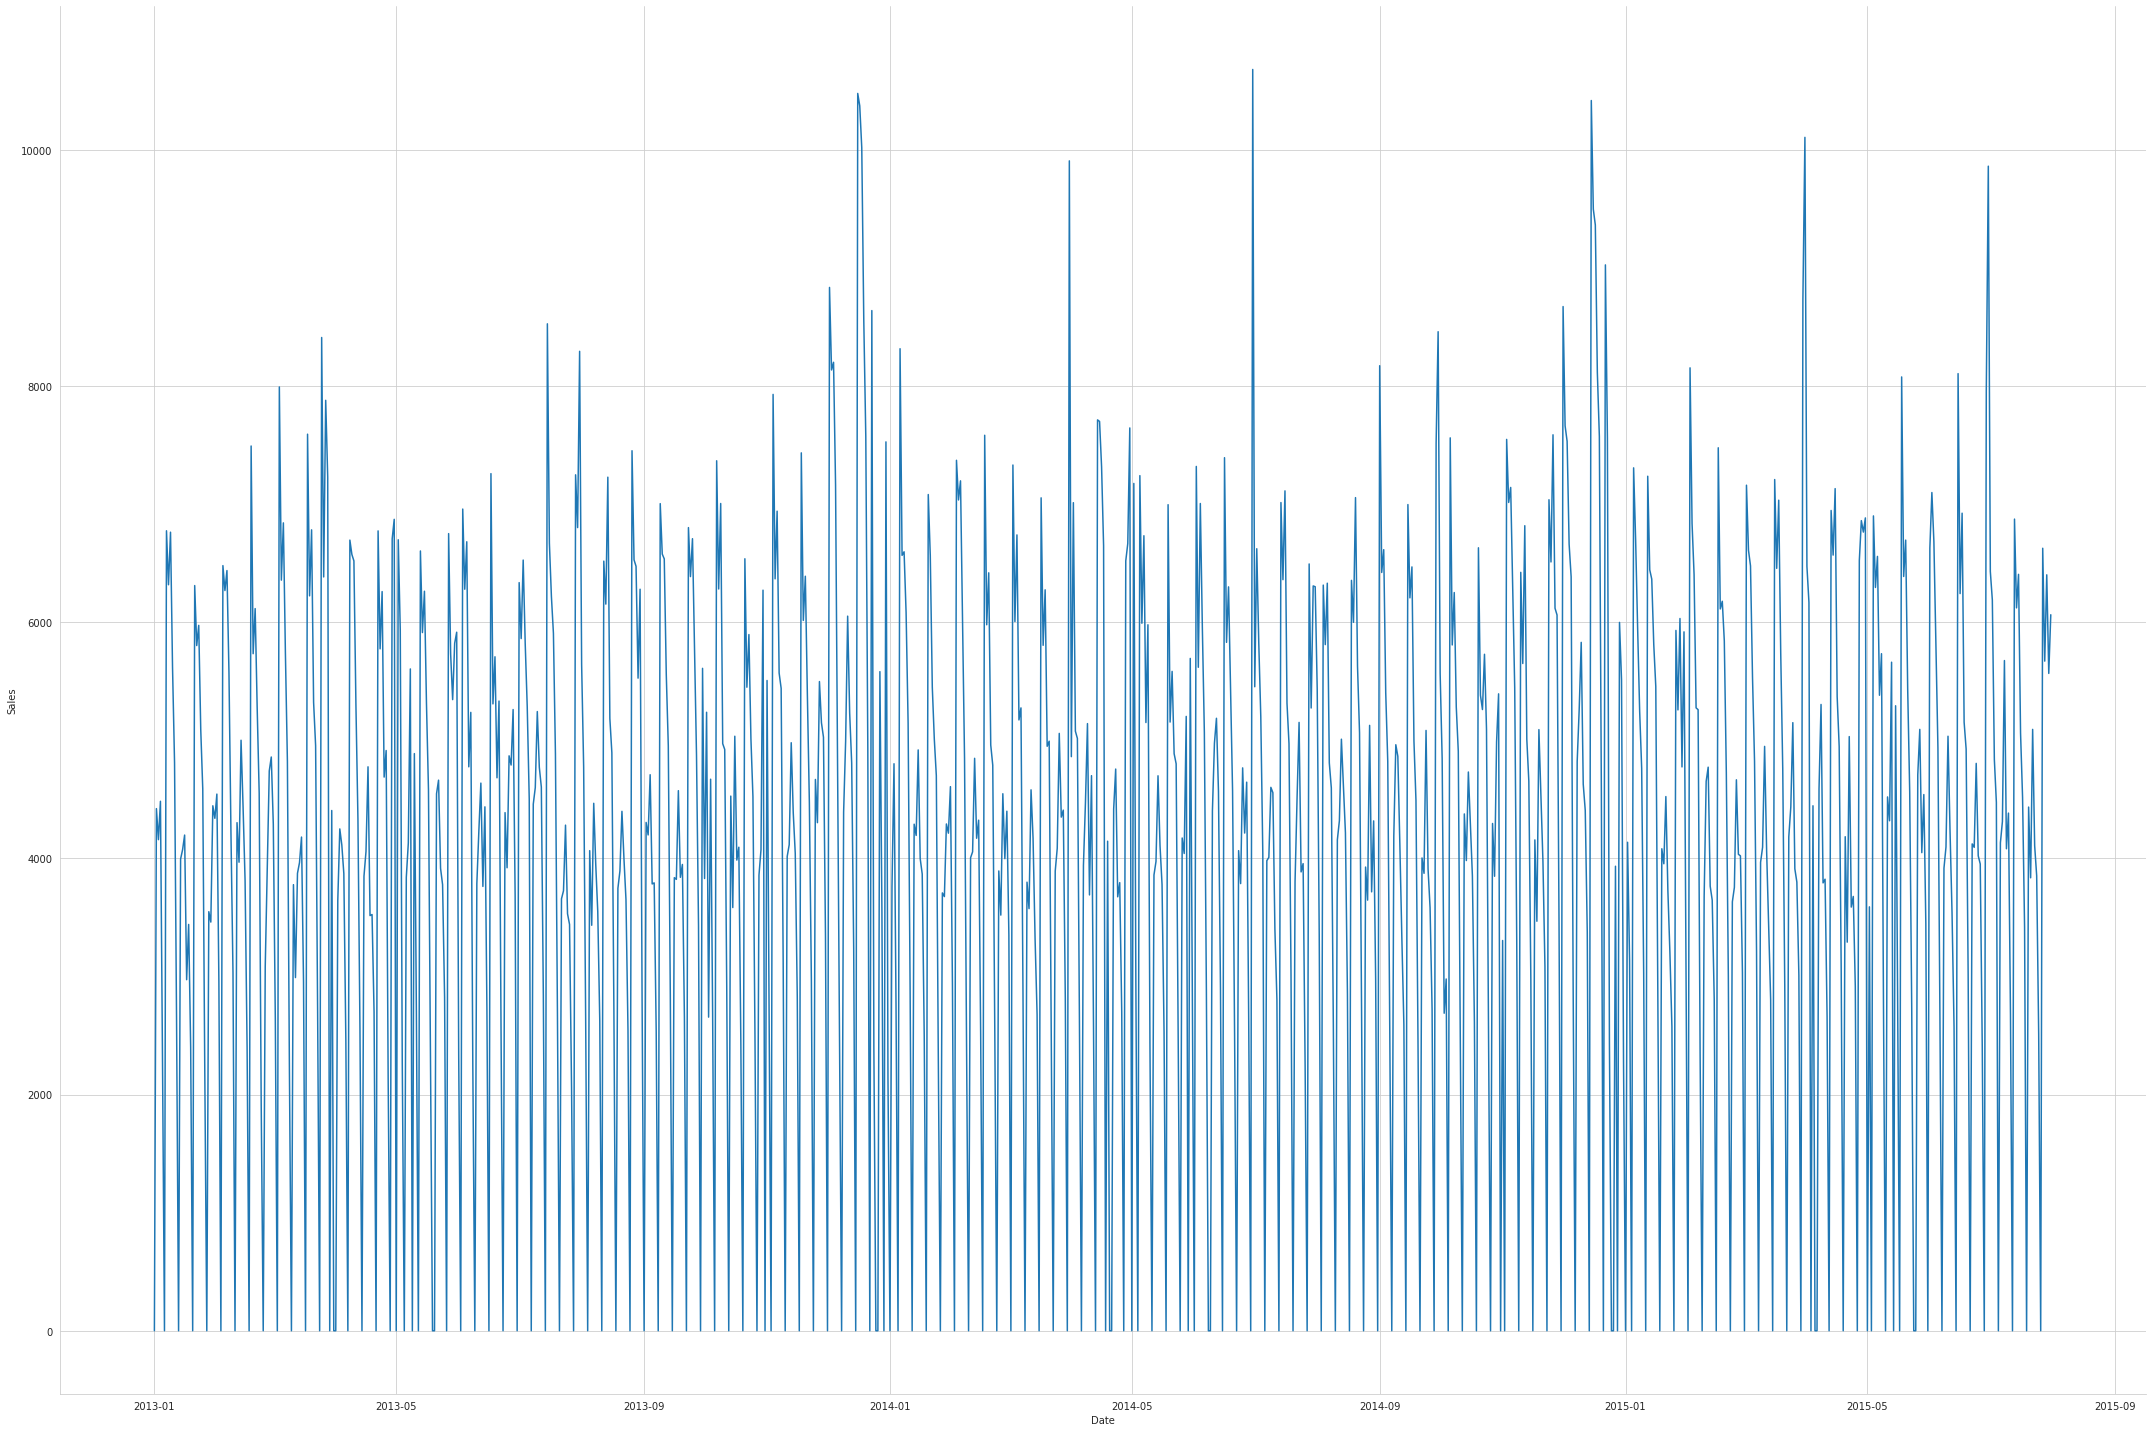

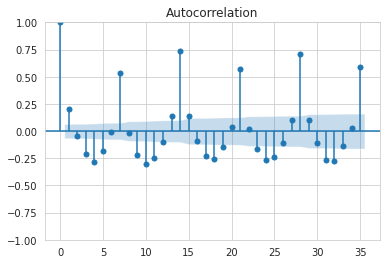

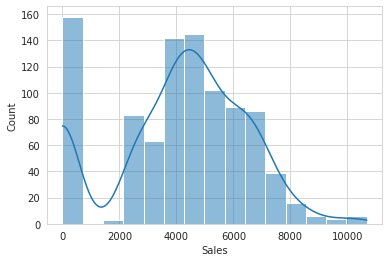

t-statistic value                                             0.300305
pvalue                                                             0.1
usedlags                                                            53
critical values      {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%...
dtype: object
t-statistic value                                            -6.369024
pvalue                                                             0.0
usedlags                                                            21
nobs                                                               920
critical values      {'1%': -3.4374778690219956, '5%': -2.864686684...
dtype: object


/usr/local/src/git/github/bruennijs/kaggle_rossmann_sales_prediction/venv/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:2015: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


In [12]:
from pandas.plotting import lag_plot
import matplotlib.pyplot as plt

plot_series_hist_acf_kpss(Y, lags=35)

# Forecast | Oridinary least squares (statsmodels)
Naively assume we can forecast by OLS and interpret the residuals of the model.

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.917
Model:                            OLS   Adj. R-squared:                  0.915
Method:                 Least Squares   F-statistic:                     508.6
Date:                Fri, 13 May 2022   Prob (F-statistic):               0.00
Time:                        08:50:17   Log-Likelihood:                -7481.4
No. Observations:                 942   AIC:                         1.500e+04
Df Residuals:                     921   BIC:                         1.511e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Promo           1966.8595     54.402     36.154      0.000    1860.093    2073.626
SchoolHoliday    120.4046     74.501      1.616      0.106     -25.807     266.617
StateHoliday_0  4660.6321    101.369     45.977      0.000    4461.691    4859.574
StateHoliday_a  2866.6939    509.517      5.626      0.000    1866.745    3866.642
StateHoliday_b  6.037e-12   8.49e-13      7.115      0.000    4.37e-12     7.7e-12
StateHoliday_c  1.864e-12   4.02e-13      4.642      0.000    1.08e-12    2.65e-12
DayOfWeek_2     -638.6373     85.143     -7.501      0.000    -805.734    -471.540
DayOfWeek_3     -149.6685     85.511     -1.750      0.080    -317.487      18.150
DayOfWeek_4    -1022.2420     86.427    -11.828      0.000   -1191.858    -852.626
DayOfWeek_5    -1274.6147     86.130    -14.799      0.000   -1443.649   -1105.581
DayOfWeek_6    -2031.4215     92.412    -21.982      0.000   -2212.784   -1850.059
DayOfWeek_7    -1.056e-13   4.11e-14     -2.571      0.010   -1.86e-13    -2.5e-14
Month_2           64.7590    112.948      0.573      0.567    -156.906     286.424
Month_3          309.9427    110.653      2.801      0.005      92.782     527.103
Month_4          178.7040    112.782      1.585      0.113     -42.635     400.043
Month_5          216.0570    112.569      1.919      0.055      -4.865     436.979
Month_6          280.5906    111.498      2.517      0.012      61.770     499.411
Month_7          154.6012    112.787      1.371      0.171     -66.747     375.950
Month_8          -40.4652    131.631     -0.307      0.759    -298.796     217.866
Month_9          167.0032    124.168      1.345      0.179     -76.682     410.688
Month_10         -29.1953    126.524     -0.231      0.818    -277.505     219.114
Month_11         403.3530    124.081      3.251      0.001     159.838     646.868
Month_12        1520.2497    126.114     12.055      0.000    1272.746    1767.753
Outlier         8.114e-13     54.766   1.48e-14      1.000    -107.481     107.481
==============================================================================
Omnibus:                      167.256   Durbin-Watson:                   1.582
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1777.693
Skew:                           0.457   Prob(JB):                         0.00
Kurtosis:                       9.668   Cond. No.                     2.19e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.46e-32. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

------ Residual diagnostics --------


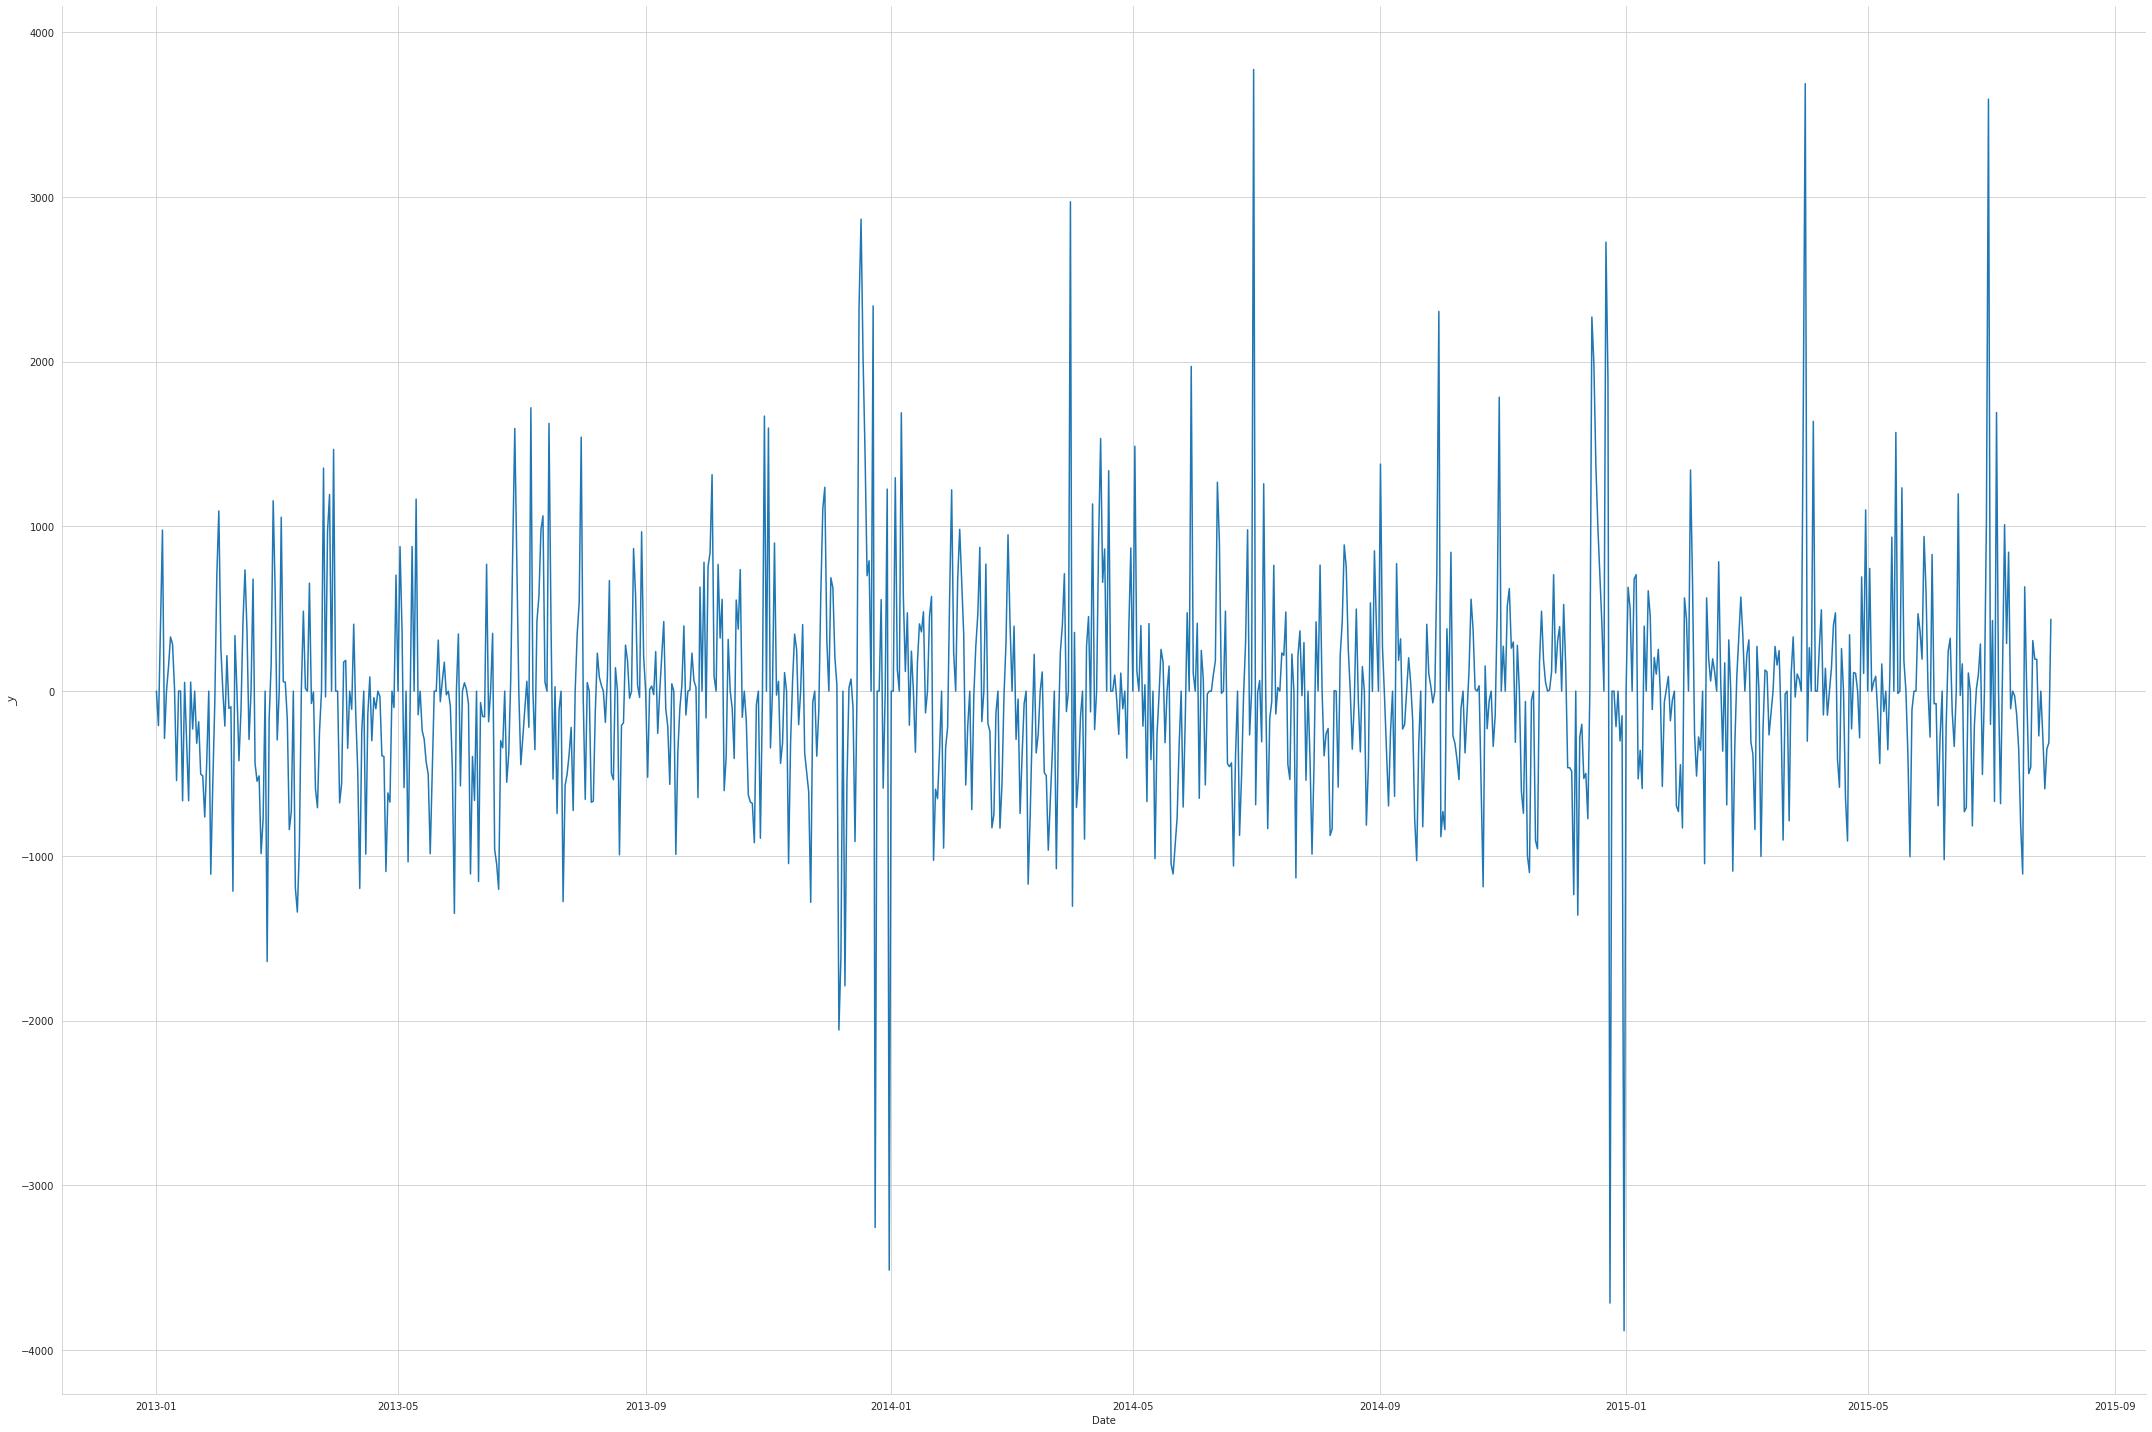

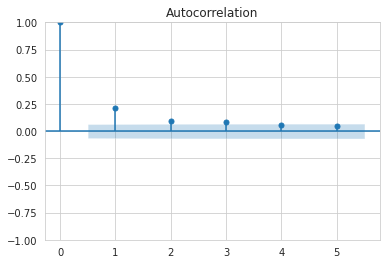

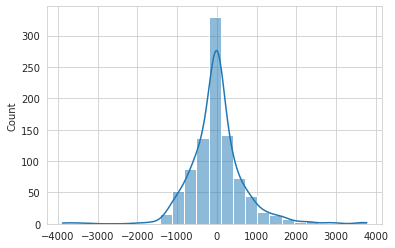

t-statistic value                                              0.22456
pvalue                                                             0.1
usedlags                                                            10
critical values      {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%...
dtype: object
t-statistic value                                            -8.142389
pvalue                                                             0.0
usedlags                                                            20
nobs                                                               921
critical values      {'1%': -3.437470108019385, '5%': -2.8646832620...
dtype: object


/usr/local/src/git/github/bruennijs/kaggle_rossmann_sales_prediction/venv/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:2015: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


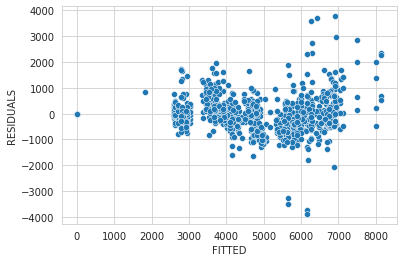

------ Actual vs fitted --------


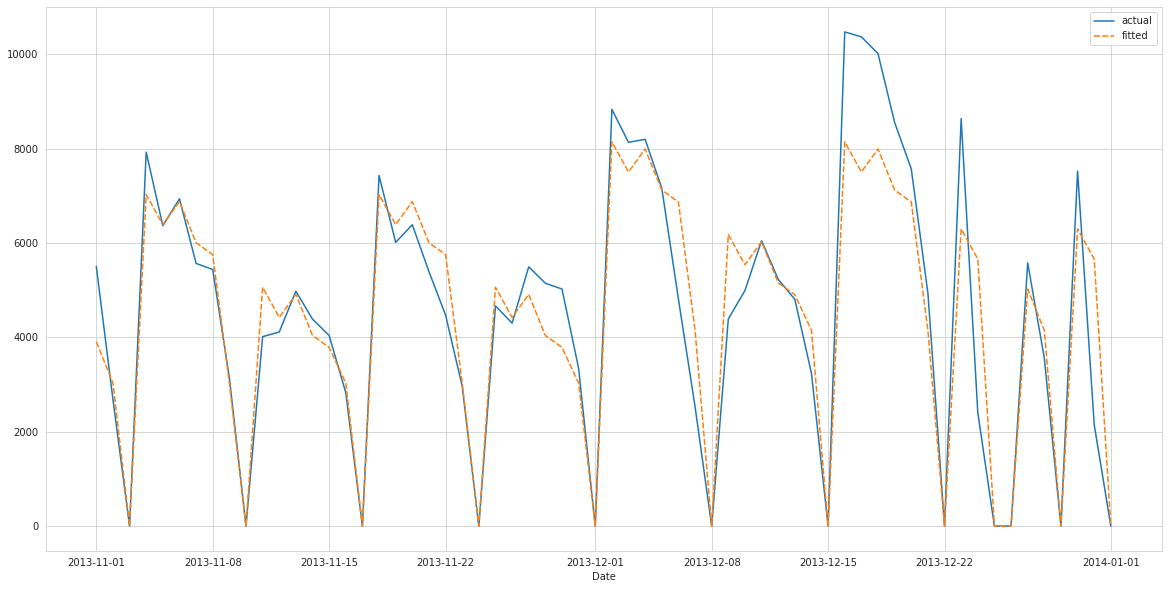

{'RMSE': 680.6841139150753,
 'MAPE': 612.9861037623048,
 'MAE': 436.8994500581721,
 'MEDIAN_AE': 293.9102578621471,
 'MAX_ABS': 3882.617899371263,
 'MIN_ABS': 8.113687480046493e-13}

------ Model errors --------


{'RMSE / standard error (SE)': 688.4006175910367,
 'RSQUARED': 0.9169778436160478,
 'RSQUARED-ADJUSTED': 0.9151749737705765}

------ Statsmodels accuracy (Cross validation) --------


In [13]:
from sklearn.metrics import make_scorer
from sklearn.linear_model._base import LinearModel
from typing import Iterator, Iterable
from sklearn.feature_selection import SelectKBest, f_regression, SequentialFeatureSelector
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from seaborn import  pairplot, scatterplot
from statsmodels.regression.linear_model import OLS, RegressionResults, PredictionResults

model: OLS = OLS(endog=Y, exog=X)
model_fit: RegressionResults = model.fit(disp=False)

# Interpretation of coefficient statistics (https://support.minitab.com/en-us/minitab/18/help-and-how-to/modeling-statistics/regression/supporting-topics/regression-models/what-is-the-standard-error-of-the-coefficient/)
# Interpretation of t-statistics: https://dss.princeton.edu/online_help/analysis/interpreting_regression.htm
model_fit.summary()
#model_fit.get_prediction()

print('------ Residual diagnostics --------')
plot_series_hist_acf_kpss(model_fit.resid, hist_bins=25)


plot_fitted_against_residuals_ols(model_fit)
#plot_residuals_against_predictors(model_fit, X)

print('------ Actual vs fitted --------')
plot_actual_and_fitted_values(Y['2013-11':'2014-01-01'], model_fit)

model_errors(Y, model_fit)
print('------ Model errors --------')
model_errors_precalculated(model_fit)

print('------ Statsmodels accuracy (Cross validation) --------')
def model_accuracy_statsmodels(model_creator, x: DataFrame, y: Series, cv: Iterable[tuple[DataFrame, DataFrame]], plot: bool = False):
    # n_splits x train/test sets with test_size x test oberservations each
    for train_idx, test_idx in cv:

        y_train = y.iloc[train_idx]
        y_test  = y.iloc[test_idx]
        x_train = x.iloc[train_idx]
        x_test  = x.iloc[test_idx]

        model: OLS = model_creator(y_train, x_train)
        fit_result: RegressionResults = model.fit()

        predict_result: PredictionResults = fit_result.get_prediction(exog=x_test)
        print(predict_result.summary_frame())

        print(errors(y=y_test, y_pred=predict_result.predicted_mean))
        #print(y_test)

#model_accuracy_statsmodels(lambda y, x: OLS(endog=y, exog=x), X, Y, cv=TimeSeriesSplit(n_splits=3, test_size=1).split(X))

# Forecast | Feature reduction using linear regression (scikit)
Using iterative methods for feature selection will finds features leading to the model with the best predictive accuracy cause univariate (each feature significance to the dependent variable only) and model based (analysis of amount of coeffiecients and errors does not see correlation between them and measures its importance only feature by feature).
See [here](https://otexts.com/fpp3/selecting-predictors.html) for more details.

------ Scikit | Accuracy using all features --------


{'scores': array([0.95453854, 0.93235667, 0.89198936, 0.9435793 , 0.85658375,
        0.87382902, 0.93275065, 0.96747531, 0.88875928, 0.94054697,
        0.89545064, 0.91630906]),
 'scores stats': count    12.000000
 mean      0.916181
 std       0.034504
 min       0.856584
 25%       0.891182
 50%       0.924333
 75%       0.941305
 max       0.967475
 dtype: float64}

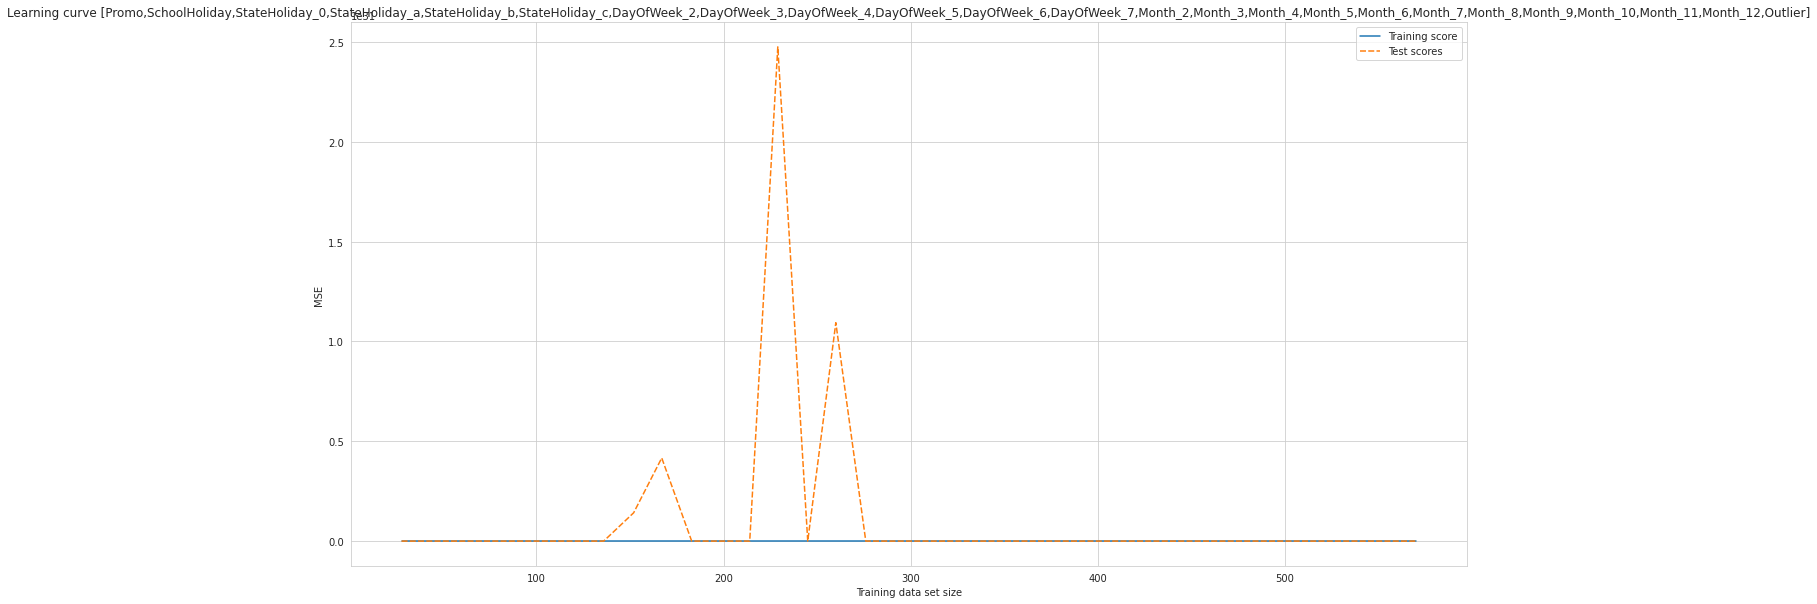

In [14]:
from collections import namedtuple
from sklearn.metrics._scorer import r2_scorer, neg_mean_squared_error_scorer
from sklearn.linear_model import LinearRegression


def model_accuracy_scikit(model: LinearRegression, x: DataFrame, y: Series, cv: Iterable[tuple], scorer=r2_scorer):
    # n_splits x train/test sets with test_size x test oberservations each

    scores = cross_val_score(estimator=model, X=x, y=y,
                             cv=cv,
                             scoring=scorer)
    #scoring=make_scorer(mean_squared_error, squared=False, greater_is_better=True))  # Returns -1*RMSE == std deviation to have a the higher the score the better

    return {'scores': scores, 'scores stats': Series(scores).describe()}
    #print(errors(y=y_test, y_pred=predict_result.predicted_mean))

# Train: Last 12 months with last 7 days of next month each as test data set
#cv_splitter = test_splitter(X, n_splits=6, test_size=31, n_last_test_items=7)
cv_splitter = TimeSeriesSplitWrapper(n_last_test_items=31, n_splits=12, test_size=31)

print('------ Scikit | Accuracy using all features --------')

model = LinearRegression()
model_accuracy_scikit(model=model, x=X, y=Y, cv=cv_splitter)
plot_line(data=to_learning_curve_df(estimator=model, X=X, y=Y, cv=cv_splitter),
          title='Learning curve [%s]' % ','.join(X.columns),
          xlabel='Training data set size',
          ylabel='MSE')

#model_accuracy_scikit(LinearRegression(), X, Y, cv_splitter, scorer=make_scorer(mean_squared_error, greater_is_better=False, squared=False))   # using 7 consequtive days
# model_accuracy_scikit(LinearRegression(), X, Y, cv_splitter, scorer=make_scorer(mean_absolute_percentage_error, greater_is_better=False))   # using 7 consequ



# Result interpretation | All features
You can see a gap in the the [learning curve](https://scikit-learn.org/stable/modules/learning_curve.html#learning-curve) (see [Learning curve tutorial](https://zahidhasan.github.io/2020/10/13/bias-variance-trade-off-and-learning-curve.html)) between training and test error so that the model overfits the training data and does not predict the validation / test data well well. We see that the curves are constant after 360 days so collection more training data will probably nit increase the score.

In [15]:
print('------ Scikit | Iterate over multiple amount of features and select with best accuracy --------')

class FeatureSelection(BaseEstimator, TransformerMixin):

    def __init__(self, y: Series, cv, n_features_to_select_threshold=4, direction='backward', model = LinearRegression()) -> None:
        super().__init__()
        self.model = model
        self.direction = direction
        self.n_features_to_select_threshold = n_features_to_select_threshold
        self.cv = cv
        self.y = y

    @property
    def scores(self) -> DataFrame:
        return self.scores_

    def transform(self, x: DataFrame) -> DataFrame:
        '''
        Selects model / columns with lowest CV value (Mean of all MSEs using cross validation)
        :param x:
        :return: New Dataframe with only selected columns
        '''
        self.scores_: DataFrame = DataFrame(self.feature_selection_scores(x))

        best_fit_ = self.scores_.set_index('CV').loc[self.scores_['CV'].min()]

        return X[best_fit_.features_selected]


    def feature_selection_scores(self, x:DataFrame) -> Tuple:
        '''

        :param x:
        :return: Named tuple with keys:
        features_selected = count of features
        r2 = r² score of fitted values against model
        r2 = r² adjusted score of fitted values against model
        CV = cross validation score of fitted values
        '''
        Result = namedtuple('FeatureSelectResult', 'features_selected feature_count r2 r2_adjusted CV')

        def feature_count_iterator():
            if self.direction == 'backward':
                return range(self.n_features_to_select_threshold, x.columns.size)
            return range(1, self.n_features_to_select_threshold)

        for feature_count in feature_count_iterator():

            sfs: SequentialFeatureSelector = SequentialFeatureSelector(self.model,
                                                                       n_features_to_select=feature_count,
                                                                       scoring=r2_scorer,
                                                                       #scoring=make_scorer(mean_squared_error, squared=False, greater_is_better=False),
                                                                       cv=self.cv,
                                                                       direction=self.direction,
                                                                       n_jobs=6)
            x_selected = sfs.fit_transform(x, y=self.y)
            x_selected_column_names = X.columns[sfs.get_support()].to_series()


            self.model.fit(x_selected, self.y)
            # 1. R² on fitted values
            r2_: float = r2_scorer(self.model, x_selected, self.y)

            # 2. Adjusted R² on fitted values
            r2_adjusted_: float = make_scorer(r2_adjusted_scorer, T=self.y.size, k=feature_count)(self.model, x_selected, self.y)

            # 3. Future data prediction ability -> cross validation with mean of MSEs of all folds (https://otexts.com/fpp3/selecting-predictors.html#cross-validation)
            CV_ = cross_val_score(self.model, X=x_selected, y=self.y, scoring=make_scorer(mean_squared_error), cv=self.cv).mean()

            df_ = Result(x_selected_column_names.tolist(), x_selected_column_names.size, r2_, r2_adjusted_, CV_)

            yield df_



fs = FeatureSelection(y=Y, n_features_to_select_threshold=2, cv=cv_splitter, direction='backward', model=model)
X_selected: DataFrame = fs.transform(X)
fs.scores


------ Scikit | Iterate over multiple amount of features and select with best accuracy --------


,features_selected,feature_count,r2,r2_adjusted,CV
0,"[Promo, Outlier]",2,0.828928,0.828563,996442.625695
1,"[Promo, DayOfWeek_6, Outlier]",3,0.865306,0.864875,820238.011969
2,"[Promo, DayOfWeek_5, DayOfWeek_6, Outlier]",4,0.879422,0.878907,708537.790356
3,"[Promo, DayOfWeek_4, DayOfWeek_5, DayOfWeek_6,...",5,0.891377,0.890797,628938.091448
4,"[Promo, DayOfWeek_4, DayOfWeek_5, DayOfWeek_6,...",6,0.907693,0.907100,522562.731448
5,"[Promo, StateHoliday_a, DayOfWeek_4, DayOfWeek...",7,0.909213,0.908533,508126.198907
6,"[Promo, StateHoliday_a, DayOfWeek_4, DayOfWeek...",8,0.909541,0.908765,506725.955718
7,"[Promo, StateHoliday_a, DayOfWeek_4, DayOfWeek...",9,0.909759,0.908887,505454.584452
8,"[Promo, StateHoliday_a, DayOfWeek_4, DayOfWeek...",10,0.910465,0.909504,503608.162853
9,"[Promo, StateHoliday_a, DayOfWeek_2, DayOfWeek...",11,0.915726,0.914729,508923.050642


# Result interpretation | Feature reduction

For large T minimizing an [AIC](https://otexts.com/fpp3/selecting-predictors.html#akaikes-information-criterion) (SSEs of residuals) or minimizing CV will lead to the same model so, as you can see [here](https://otexts.com/fpp3/selecting-predictors.html#which-measure-should-we-use).
So we choose the model with the smallest CV score and take a look at:
1. The residuals should be white noise, see histogram, error correlation and plot. The variance should not change over time and be constant. Let us see where the changes in variance are in the plot and to infer possible new predictor variables [here](https://otexts.com/fpp3/regression-evaluation.html#acf-plot-of-residuals). See at which dates or date ranges the highest errors occur, maybe around holidays or no school days.
2. Overfitting or Underfitting - The [learning curve](https://scikit-learn.org/stable/modules/learning_curve.html#learning-curve) will show us whether the model suffers from bias error (overfitting) or variance error (underfitting), see [here](https://en.wikipedia.org/wiki/Bias%E2%80%93variance_tradeoff). If the model is underfitted (high bias) when the training data is not predicted well and the test data of cource not too. We should see that training-  and test curve converge to a niveau with high errors. If the model is overfitted (low bias but high variance) there is a high score on the training data but low on the test data. If there is also a upwards trend in the test curve we could fix the high variance problem by adding MORE training data. Otherwise we must use a less complex model and find more features by feature engineering.
3. Check for patterns in plot of 'residuals vs fitted' whether there is a relationship between errors and its fitted value. Maybe a logarithmic transformation of the dependent variable is needed
4. Correlations of the selected predictors and eliminate predictors that are dependent of each other.

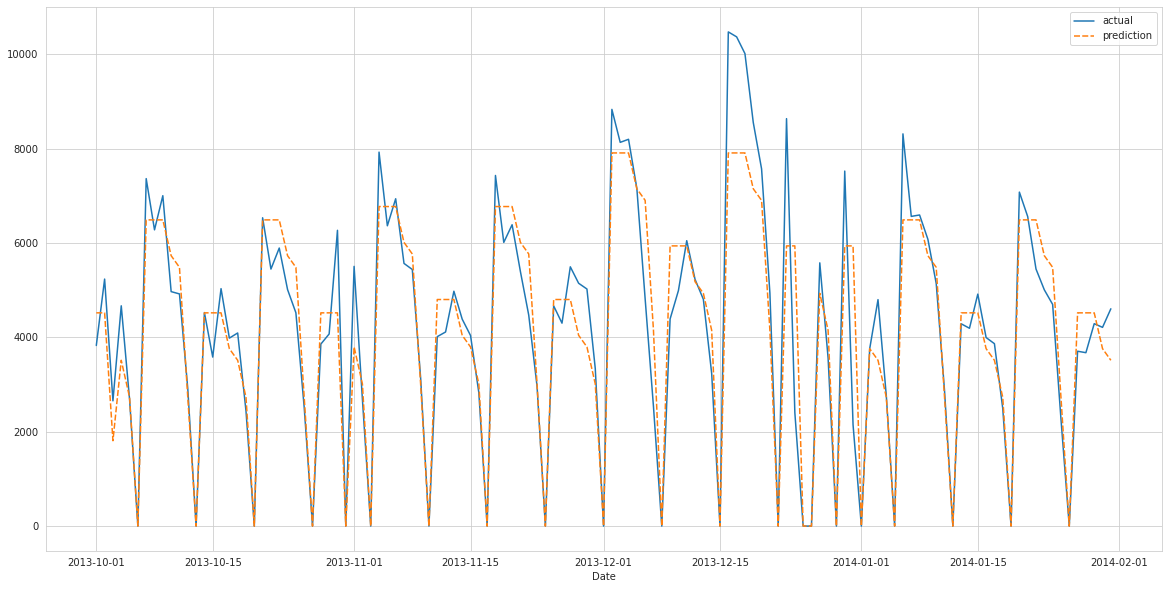

{'residuals_n_max': Date
 2014-06-30    4032.952107
 2015-03-31    3415.731351
 2014-03-31    3216.731351
 2015-06-30    3213.952107
 2014-12-22    3085.534402
 2013-12-23    2698.534402
 2013-12-16    2566.348691
 2014-12-15    2506.348691
 2013-12-17    2461.348691
 2014-05-30    2178.063227
 2013-12-18    2106.348691
 2015-03-30    2041.731351
 2013-07-15    2034.943229
 2014-09-30    1967.943229
 2014-01-06    1823.943229
 dtype: float64,
 'residuals_n_min': Date
 2013-12-31   -3793.465598
 2014-12-31   -3672.465598
 2013-12-24   -3534.465598
 2014-12-24   -3504.465598
 2013-12-06   -2090.717023
 2013-03-12   -1729.082938
 2014-04-01   -1631.056771
 2013-12-07   -1617.000139
 2013-12-09   -1549.465598
 2013-02-25   -1437.871059
 2013-06-18   -1340.047893
 2014-05-20   -1338.056771
 2014-11-18   -1336.675297
 2013-11-22   -1295.926723
 2013-02-08   -1284.122485
 dtype: float64,
 'distribution': count    9.420000e+02
 mean     5.986059e-13
 std      7.072526e+02
 min     -3.793466e+0

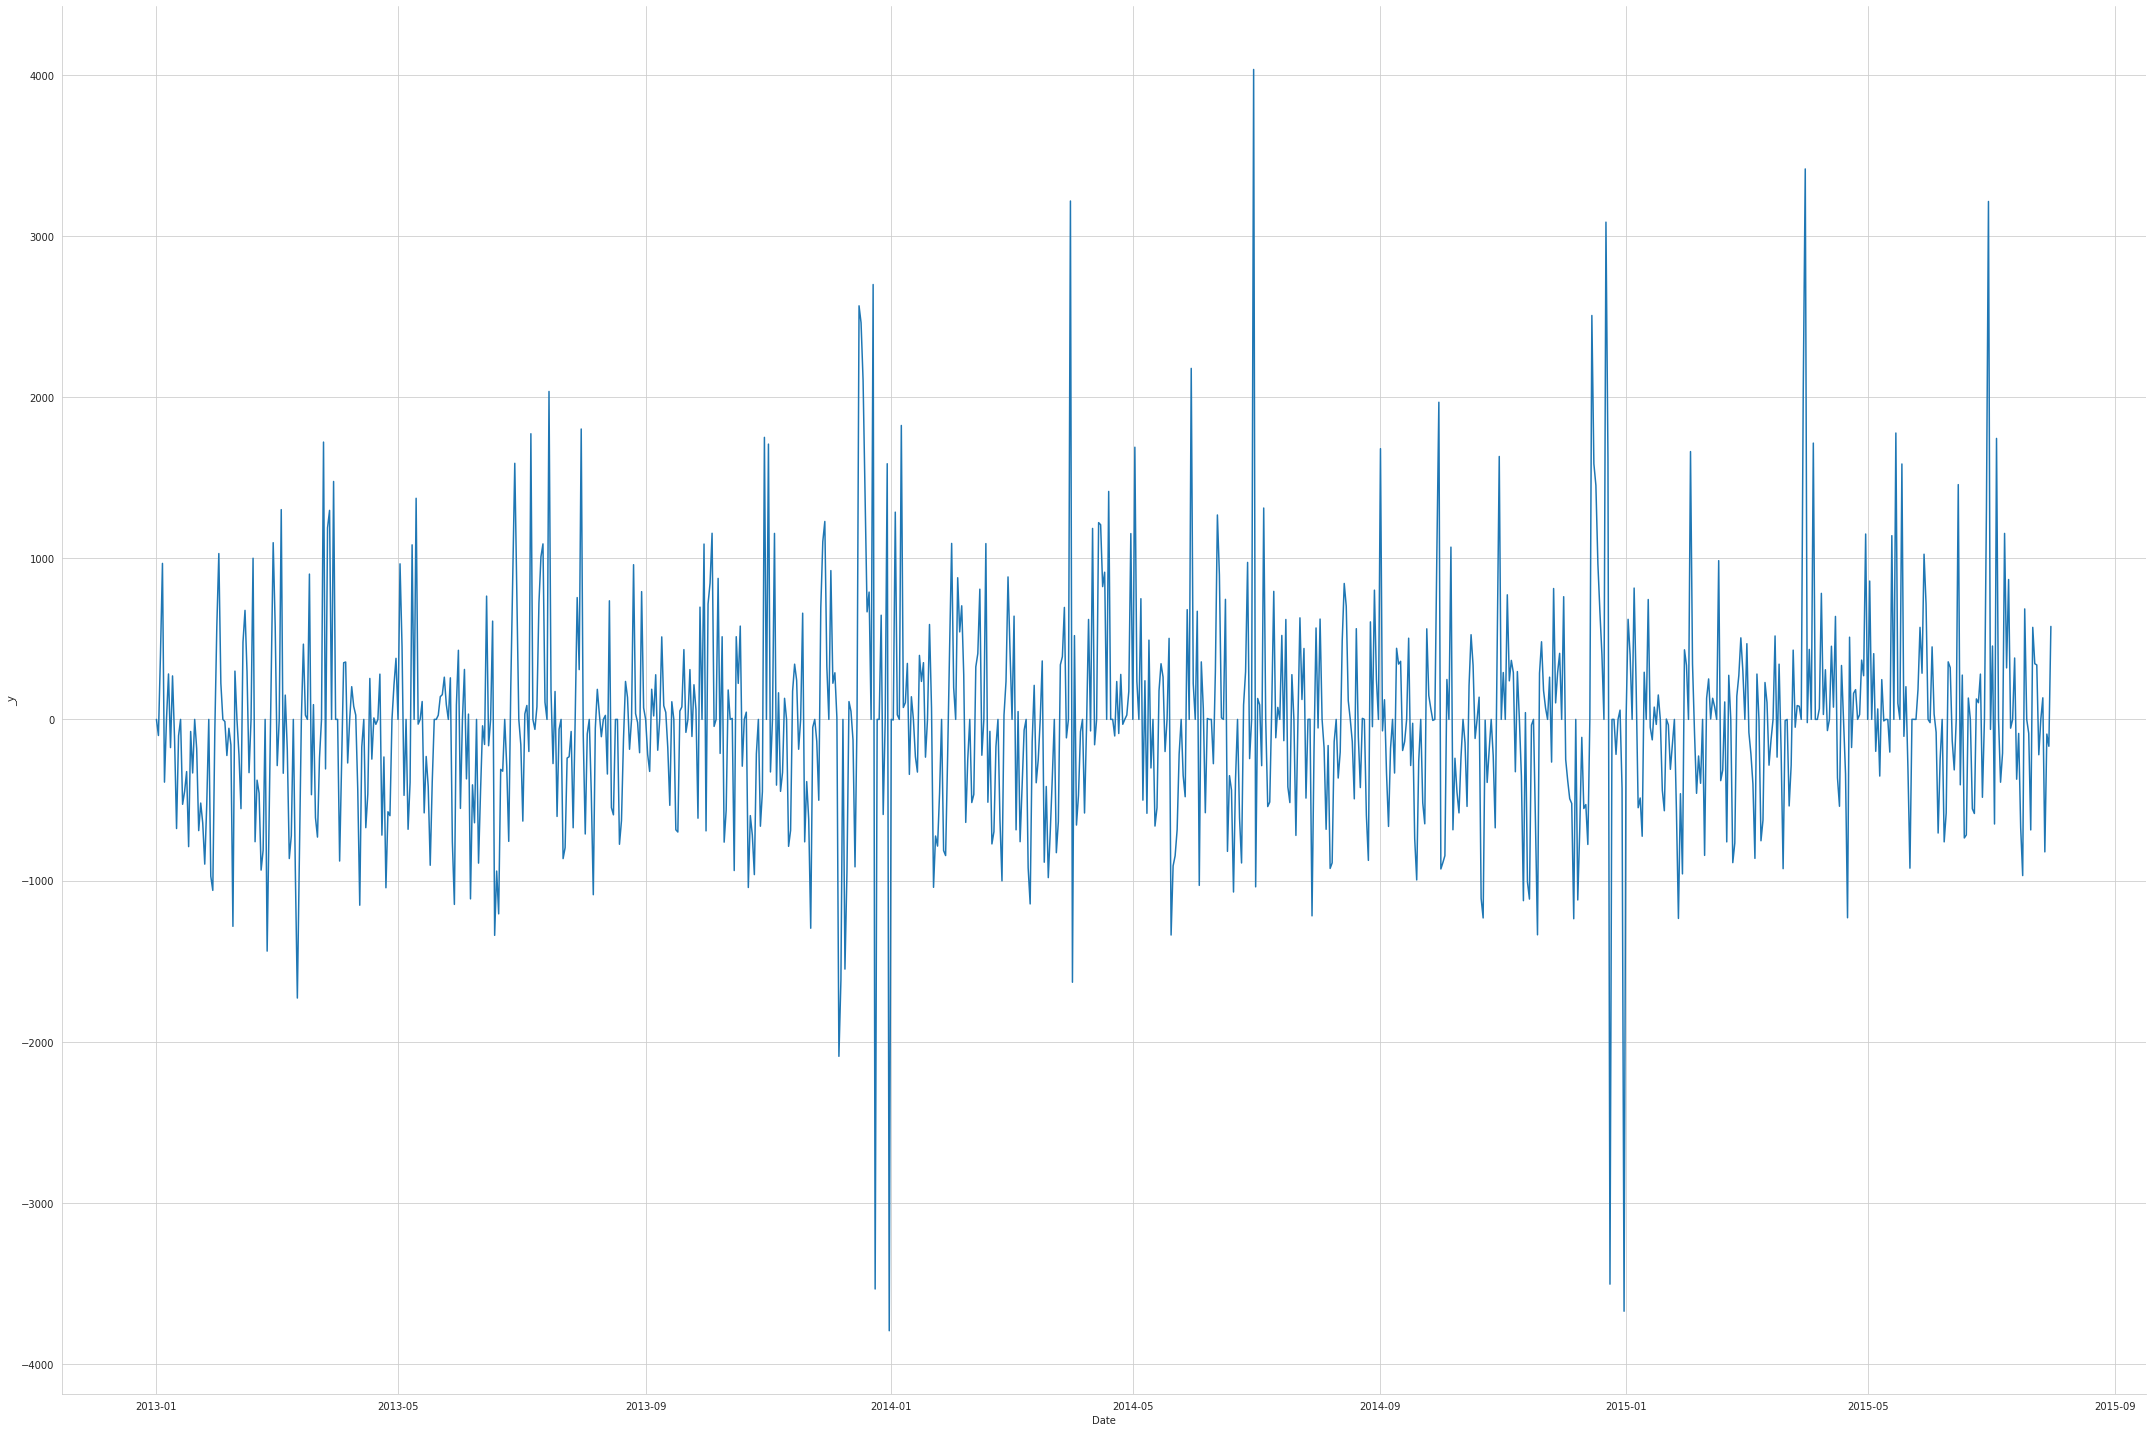

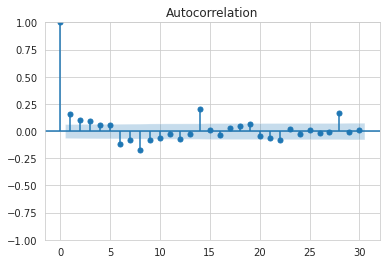

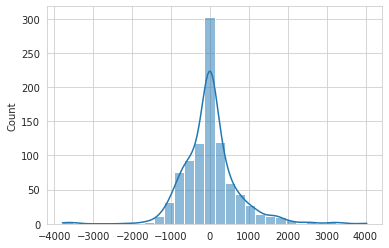

/usr/local/src/git/github/bruennijs/kaggle_rossmann_sales_prediction/venv/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:2015: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


t-statistic value                                             0.286746
pvalue                                                             0.1
usedlags                                                            10
critical values      {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%...
dtype: object
t-statistic value                                            -8.415362
pvalue                                                             0.0
usedlags                                                            15
nobs                                                               926
critical values      {'1%': -3.4374315551464734, '5%': -2.864666262...
dtype: object


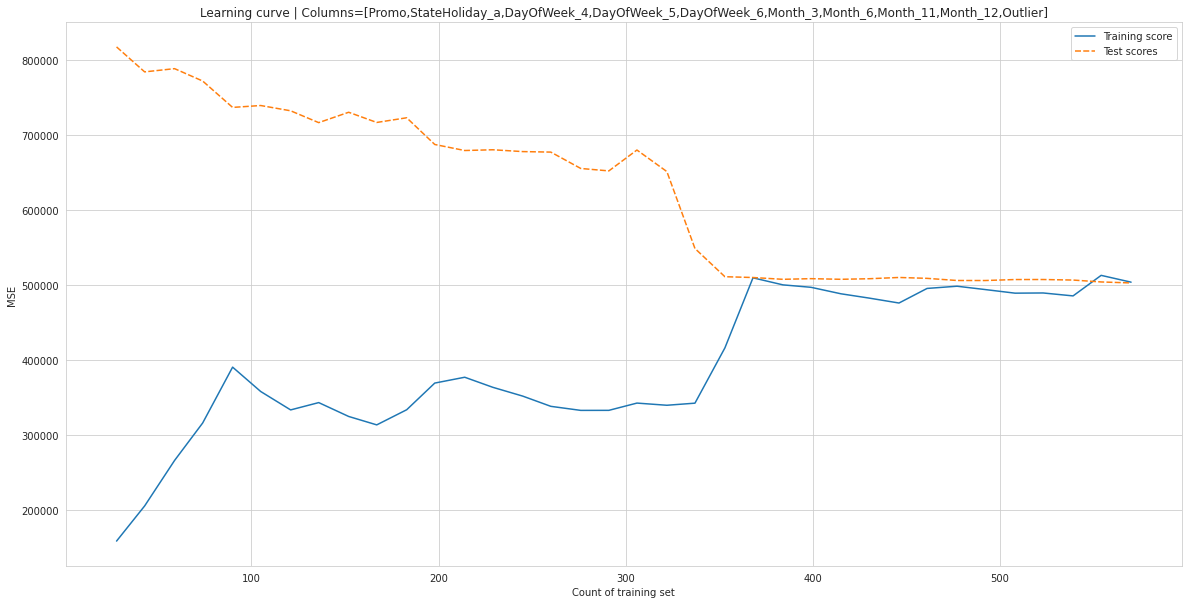

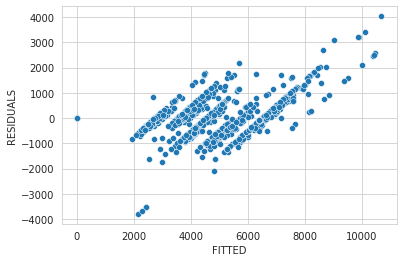

,Promo,StateHoliday_a,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6,Month_3,Month_6,Month_11,Month_12,Outlier
Promo,1.000000,0.011829,0.149365,0.124466,-0.315980,0.064512,0.038989,0.056511,0.015654,-0.348324
StateHoliday_a,0.011829,1.000000,0.049321,0.048712,-0.018784,-0.013762,-0.013567,-0.011036,-0.010805,-0.020707
DayOfWeek_4,0.149365,0.049321,1.000000,-0.157243,-0.160757,0.018367,0.021685,0.015442,-0.008485,-0.177212
DayOfWeek_5,0.124466,0.048712,-0.157243,1.000000,-0.162217,0.016404,0.019726,0.027508,0.004030,-0.178822
DayOfWeek_6,-0.315980,-0.018784,-0.160757,-0.162217,1.000000,0.033796,0.026172,0.036868,0.014093,-0.182817
Month_3,0.064512,-0.013762,0.018367,0.016404,0.033796,1.000000,-0.087752,-0.071381,-0.069889,-0.133939
Month_6,0.038989,-0.013567,0.021685,0.019726,0.026172,-0.087752,1.000000,-0.070367,-0.068896,-0.132036
Month_11,0.056511,-0.011036,0.015442,0.027508,0.036868,-0.071381,-0.070367,1.000000,-0.056043,-0.107403
Month_12,0.015654,-0.010805,-0.008485,0.004030,0.014093,-0.069889,-0.068896,-0.056043,1.000000,-0.105158
Outlier,-0.348324,-0.020707,-0.177212,-0.178822,-0.182817,-0.133939,-0.132036,-0.107403,-0.105158,1.000000


StateHoliday_a    0.028322
DayOfWeek_5       0.092166
Month_11          0.101299
Month_6           0.103260
Month_3           0.119177
DayOfWeek_4       0.141112
Month_12          0.207638
DayOfWeek_6       0.215461
Promo             0.707621
Outlier           0.783492
dtype: float64

In [16]:
import numpy as np

# Train: Take recent 12 months with last 31 days of each  month as test data set
cv_splitter = TimeSeriesSplitWrapper(n_last_test_items=31, n_splits=12, test_size=31)

#best_fit_ = result_.set_index('feature_count').loc[2]   # underfit

class ResidualDiagnostics():
    def __init__(self, model):
        if model is None: raise AssertionError('model may not nbe null')
        self.model_ = model

    def analyze(self, x, y) -> dict:

        y_pred_: Series = Series(data=model.predict(x), index=y.index)
        self.residuals_: Series = y - y_pred_
        return self.stats_(self.residuals_)

    @property
    def residuals(self):
        return self.residuals_

    @staticmethod
    def stats_(residuals: Series) -> dict:
        return {'residuals_n_max': residuals.sort_values(ascending=False).head(15),
                'residuals_n_min': residuals.sort_values(ascending=True).head(15),
                'distribution': residuals.describe([0.025, 0.25, 0.5, 0.75, 0.975])}


model = LinearRegression()
model = model.fit(X_selected, Y)
y_pred = Series(model.predict(X_selected), index=Y.index)


plot_time_series(actual=Y['2013-10':'2014-01'], prediction=y_pred['2013-10':'2014-01'])

# 1. Residual diagnostics
diag = ResidualDiagnostics(model=model)
diag.analyze(X_selected, Y)

plot_series_hist_acf_kpss(diag.residuals, hist_bins=30, lags=30)


# 2. Learning curve interpretation

plot_line(data=to_learning_curve_df(estimator=model, X=X_selected, y=Y, cv=cv_splitter),
          title='Learning curve | Columns=[%s]' % ','.join(X_selected.columns),
          xlabel='Count of training set',
          ylabel='MSE')

#X['StateHoliday_a'] > 0.0]

# 3. Plot Fitted vs residuals

plot_fitted_against_residuals(fitted=Y, residuals=diag.residuals)

# 4. Correlations between predictors and see whether one of each pair have been eliminated by the feature selection process
#X.corrwith(Y, method='pearson').apply(np.abs).sort_values()
X_selected.corr(method='pearson')
X_selected.corrwith(Y, method='pearson').apply(np.abs).sort_values()
# todo:
# 1. Features correlated a lot of each other remove before going on (https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.chi2.html#sklearn.feature_selection.chi2)
# 2. Use CV (create scorer impl using scikit's LeaveOneOut() splitter)  vs SSE or R² of residuals (https://otexts.com/fpp3/selecting-predictors.html#cross-validation)
# 3. Use model based SelectFromModel or https://otexts.com/fpp3/selecting-predictors.html and compare to iterative approach



# Underfit | Optimize model accuracy
We see a relative high error in the learning curve for training and test data which is caused in a high variance AND a high bias problem but they are close to each other ([see here](https://zahidhasan.github.io/2020/10/13/bias-variance-trade-off-and-learning-curve.html#over-fit--under-fit)). We see that the curves are constant after 360 days so collection more training data will probably not increase the score. We should find more predictors by looking at the dates with the highest errors.

1. Find [trend](https://otexts.com/fpp3/useful-predictors.html#trend) in the data to use t as a predictor
2. There are a lot of features before and after state holidays. Create new features indicating whether a day is x days before or after such a holiday

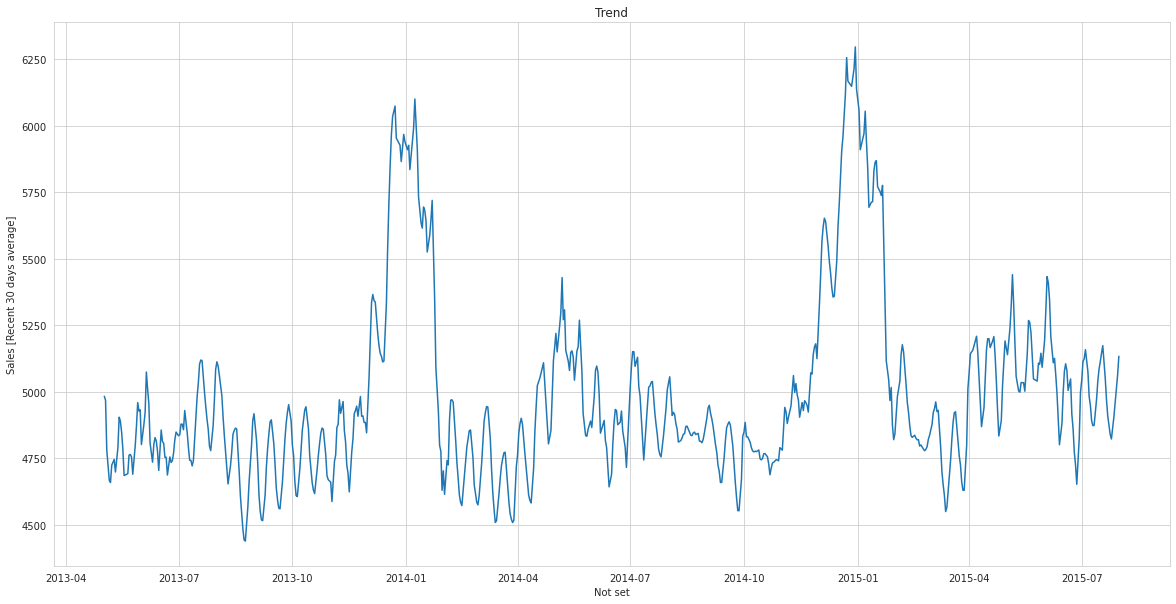

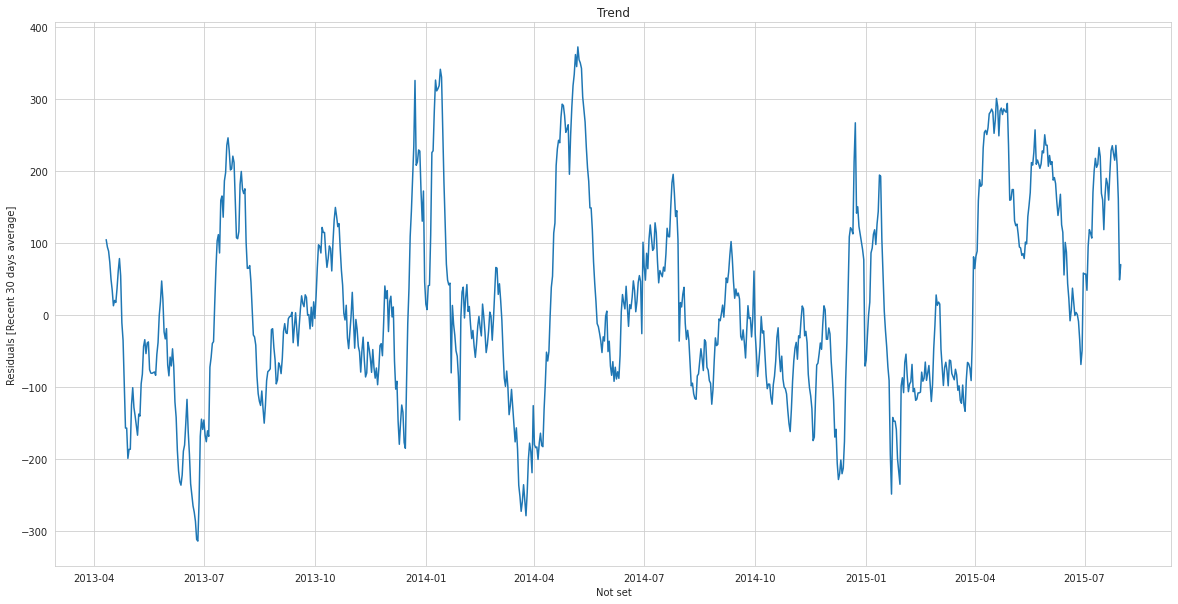

In [17]:


# 1. find trend by using rolling window
window_size_ = 30
sma_y_:Series = Y[Y > 0.0].rolling(window=window_size_, min_periods=1).mean()

sma_residuals_:Series = diag.residuals.rolling(window=window_size_, min_periods=1).mean()

plot_line(data=sma_y_[100:], title='Trend', ylabel='Sales [Recent %d days average]' % window_size_)
plot_line(data=sma_residuals_[100:], title='Trend', ylabel='Residuals [Recent %d days average]' % window_size_)


In [18]:
# 2. Engineeer pre/post state holiday features
model = LinearRegression()

#Pipeline(steps={})
X, Y = FeaturePreparation(transform_pre_post_holiday_indicators=True).transform(df_train)

fs = FeatureSelection(y=Y, n_features_to_select_threshold=2, cv=cv_splitter, direction='backward', model=model)
X_selected: DataFrame = fs.transform(X)

fs.scores
X_selected


,features_selected,feature_count,r2,r2_adjusted,CV
0,"[Promo, Outlier]",2,0.828928,0.828563,996442.625695
1,"[Promo, DayOfWeek_6, Outlier]",3,0.865306,0.864875,820238.011969
2,"[Promo, DayOfWeek_5, DayOfWeek_6, Outlier]",4,0.879422,0.878907,708537.790356
3,"[Promo, DayOfWeek_4, DayOfWeek_5, DayOfWeek_6,...",5,0.891377,0.890797,628938.091448
4,"[Promo, DayOfWeek_4, DayOfWeek_5, DayOfWeek_6,...",6,0.907693,0.907100,522562.731448
5,"[Promo, StateHoliday_a, DayOfWeek_4, DayOfWeek...",7,0.909213,0.908533,508126.198907
6,"[Promo, StateHoliday_a, DayOfWeek_4, DayOfWeek...",8,0.914141,0.913405,474982.171245
7,"[Promo, StateHoliday_a, DayOfWeek_4, DayOfWeek...",9,0.916017,0.915206,468004.930989
8,"[Promo, StateHoliday_a, DayOfWeek_2, DayOfWeek...",10,0.921356,0.920512,468137.842135
9,"[Promo, StateHoliday_a, DayOfWeek_2, DayOfWeek...",11,0.921722,0.920796,464947.978748


,Promo,SchoolHoliday,StateHoliday_0,StateHoliday_a,StateHoliday_b,StateHoliday_c,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,...,Month_10,Month_11,Month_12,StateHoliday_a_1day_before,StateHoliday_a_1day_after,StateHoliday_b_1day_before,StateHoliday_b_1day_after,StateHoliday_c_1day_before,StateHoliday_c_1day_after,Outlier
Date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2013-01-02,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2013-01-03,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-01-04,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-01-05,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-07-27,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-07-28,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-07-29,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


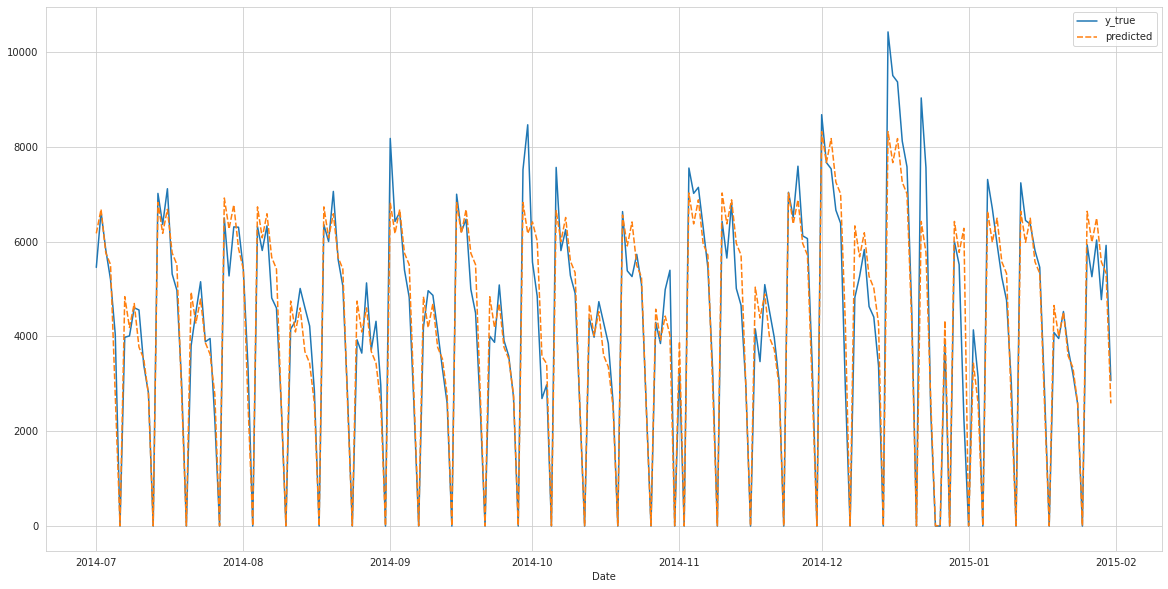

{'residuals_n_max': Date
 2014-06-30    3758.5
 2015-03-31    3720.5
 2015-06-30    3591.5
 2014-03-31    2963.0
 2013-12-17    2711.0
 2014-12-22    2604.0
 2014-09-30    2292.0
 2013-12-23    2217.0
 2013-12-16    2164.0
 2014-12-15    2104.0
 2013-12-18    1849.0
 2014-12-16    1836.0
 2014-12-23    1786.0
 2013-07-06    1730.0
 2015-07-04    1701.0
 dtype: float64,
 'residuals_n_min': Date
 2013-12-31   -4142.0
 2014-12-31   -4009.0
 2013-12-06   -2189.5
 2013-12-09   -1937.5
 2013-12-07   -1731.5
 2013-02-25   -1657.5
 2014-12-08   -1508.5
 2014-12-06   -1351.5
 2013-04-02   -1348.5
 2013-03-12   -1316.5
 2013-07-22   -1273.5
 2013-05-29   -1260.0
 2013-11-22   -1240.0
 2014-04-01   -1227.0
 2013-02-08   -1214.5
 dtype: float64,
 'distribution': count     942.000000
 mean       -0.271762
 std       645.825108
 min     -4142.000000
 2.5%    -1099.637500
 25%      -314.375000
 50%        -8.000000
 75%       263.500000
 97.5%    1358.887500
 max      3758.500000
 dtype: float64}

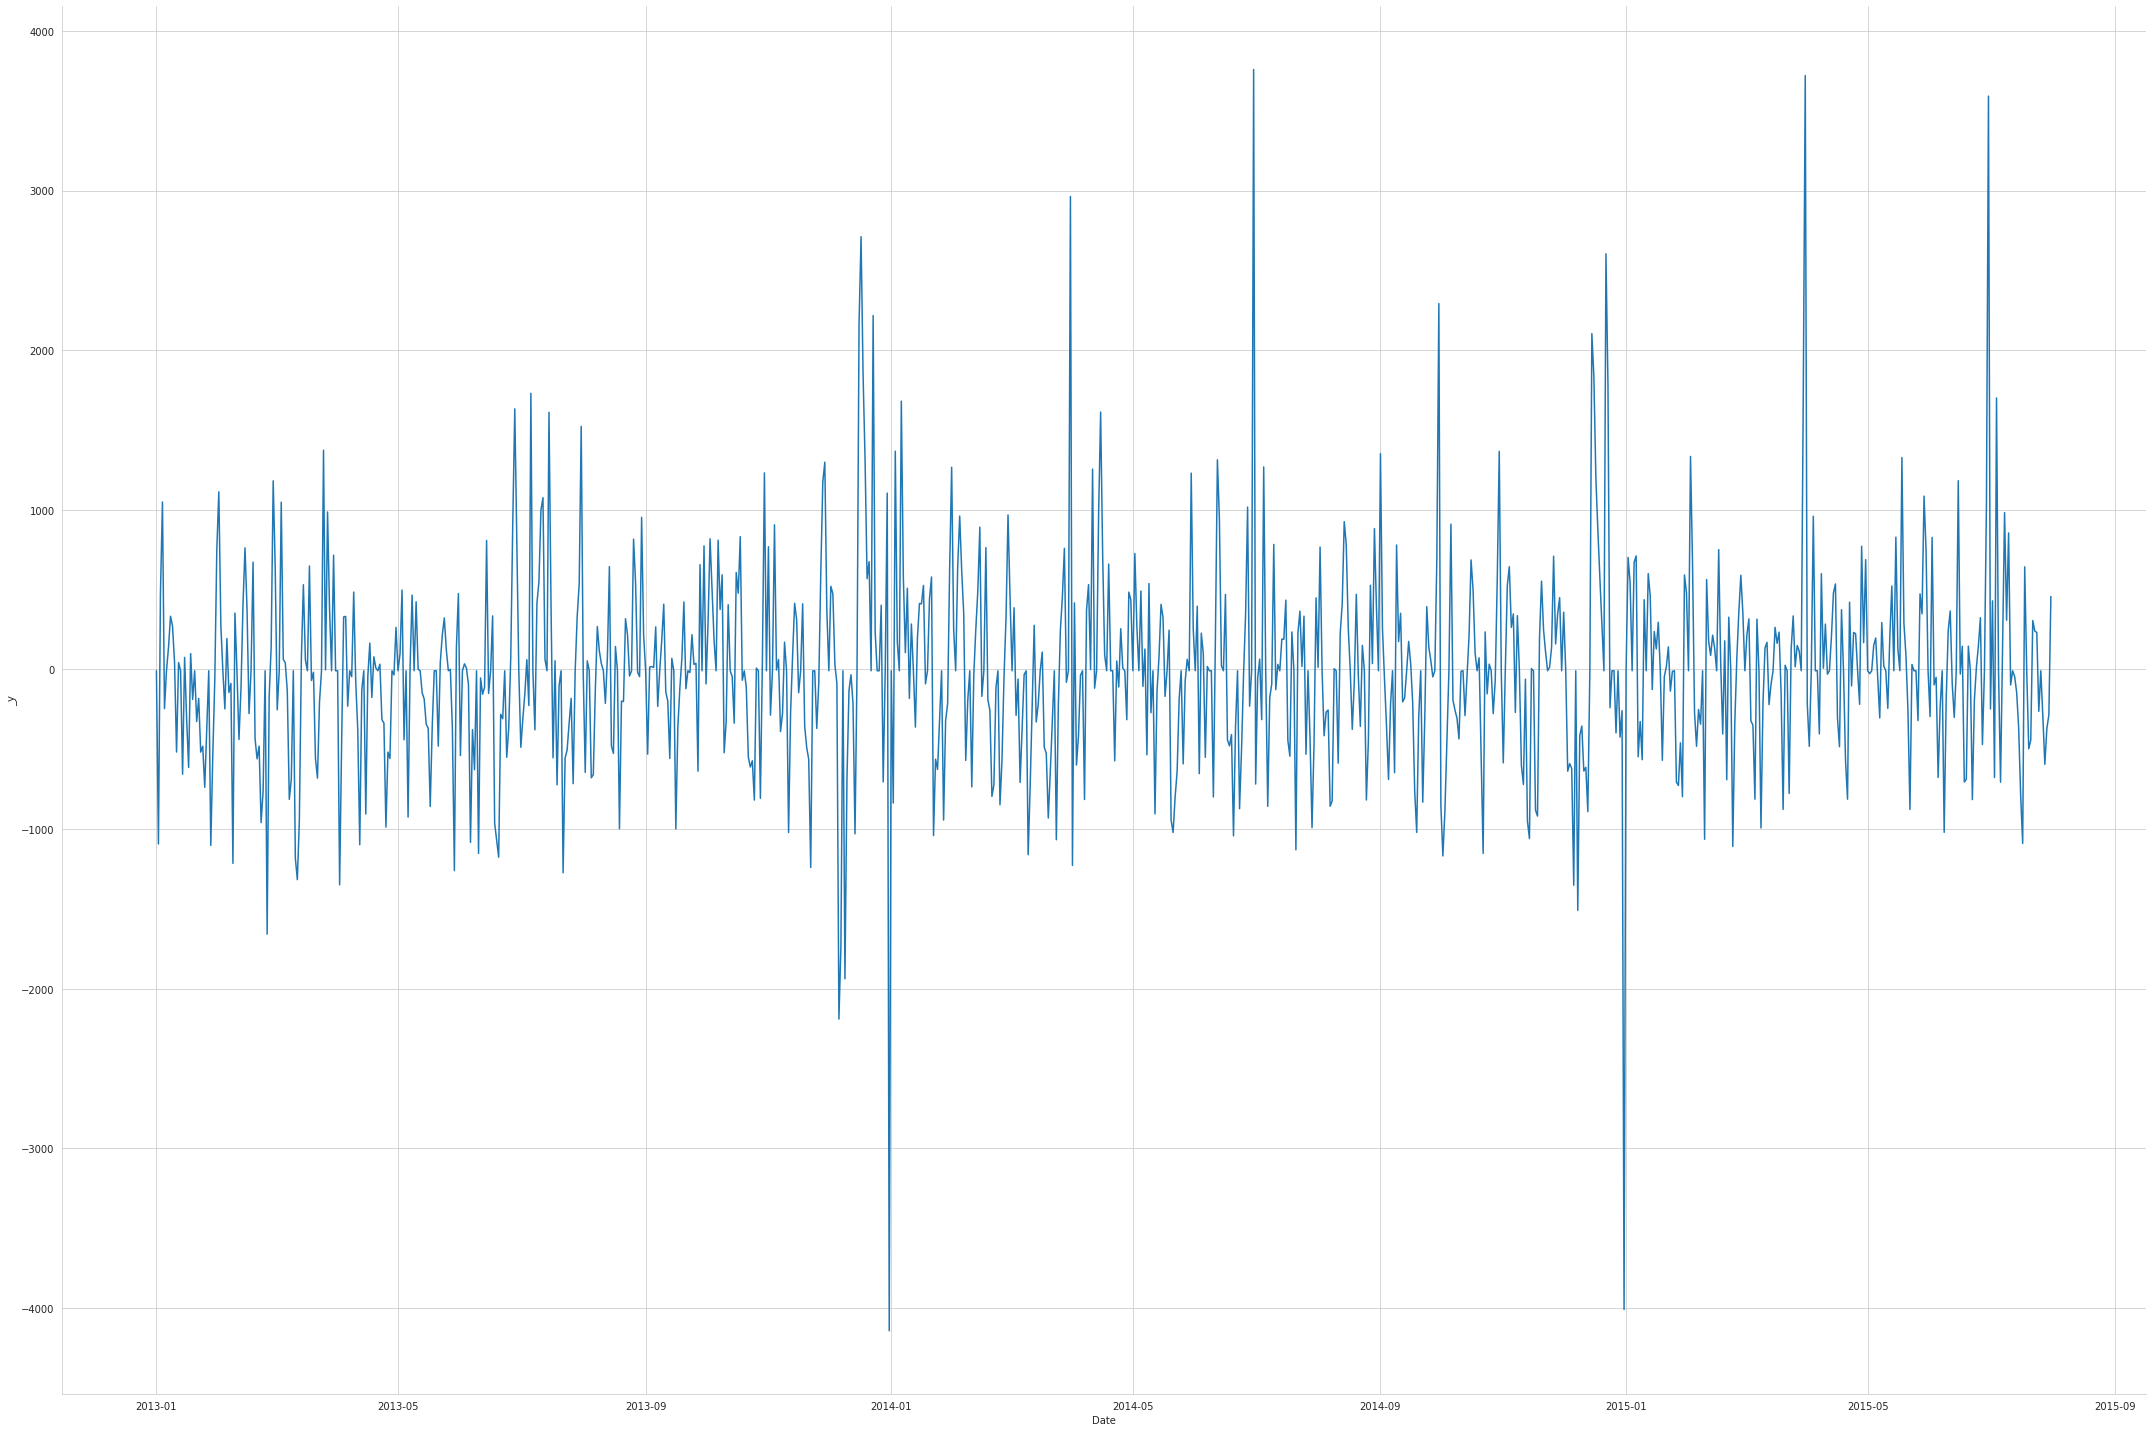

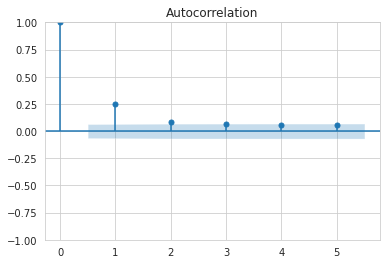

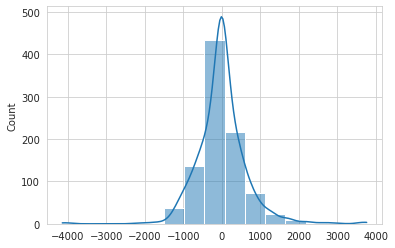

t-statistic value                                             0.264347
pvalue                                                             0.1
usedlags                                                            10
critical values      {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%...
dtype: object
t-statistic value                                            -9.428715
pvalue                                                             0.0
usedlags                                                            15
nobs                                                               926
critical values      {'1%': -3.4374315551464734, '5%': -2.864666262...
dtype: object


/usr/local/src/git/github/bruennijs/kaggle_rossmann_sales_prediction/venv/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:2015: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


In [19]:
# 2.1 Analyze error of feature selection
model = model.fit(X_selected, Y)
y_pred = Series(model.predict(X_selected), index=Y.index)

plot_time_series(y_true=Y['2014-07':'2015-01'], predicted=y_pred['2014-07':'2015-01'])

diag = ResidualDiagnostics(model=model)
diag.analyze(X_selected, Y)
plot_series_hist_acf_kpss(diag.residuals)
